In [1]:
from openparticle import *
import numpy as np
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
from openparticle import ParticleOperator
import numpy as np
import cirq
from src.lobe.system import System
from src.lobe.lobe_circuit import lobe_circuit
from src.lobe.block_encoding import add_lobe_oracle
from cirq.contrib.svg import SVGCircuit
from src.lobe.usp import add_naive_usp
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.rescale import bosonically_rescale_terms, rescale_terms_usp, get_numbers_of_bosonic_operators_in_terms, get_number_of_active_bosonic_modes
from src.lobe._utils import get_basis_of_full_system
import matplotlib.pyplot as plt
from colors import *

/Users/carterm.gustin/anaconda3/envs/phd/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
def generate_yukawa_circuit(number_of_modes, maximum_bosonic_occupation):

    operator =  yukawa_Hamiltonian(number_of_modes)
    terms = operator.to_list()

    bosonically_rescaled_terms, bosonic_rescaling_factor = bosonically_rescale_terms(terms, maximum_bosonic_occupation)
    coefficients = [term.coeff for term in bosonically_rescaled_terms]


    norm = sum(np.abs(coefficients))
    target_state = get_target_state(coefficients)
    asp_rescaling_factor = (bosonic_rescaling_factor * norm)

    number_of_modes = max([term.max_mode() for term in terms]) + 1

    number_of_ancillae = (
        1000  # Some arbitrary large number with most ancilla disregarded
    )
    number_of_index_qubits = max(int(np.ceil(np.log2(len(terms)))), 1)
    number_of_rotation_qubits = max(get_number_of_active_bosonic_modes(terms)) + 1
    
    usp_rescaled_terms, usp_rescaling_factor = rescale_terms_usp(bosonically_rescaled_terms)
    usp_rescaling_factor *= (bosonic_rescaling_factor * (1 << number_of_index_qubits))

    # Declare Qubits
    validation = cirq.LineQubit(0)
    clean_ancillae = [cirq.LineQubit(i + 1) for i in range(number_of_ancillae)]
    rotation_qubits = [
        cirq.LineQubit(i + 1 + number_of_ancillae)
        for i in range(number_of_rotation_qubits)
    ]
    index_register = [
        cirq.LineQubit(i + 1 + number_of_ancillae + number_of_rotation_qubits)
        for i in range(number_of_index_qubits)
    ]
    system = System(
        number_of_modes=number_of_modes,
        maximum_occupation_number=maximum_bosonic_occupation,
        number_of_used_qubits=1
        + number_of_ancillae
        + number_of_rotation_qubits
        + number_of_index_qubits,
        has_fermions=operator.has_fermions,
        has_antifermions=operator.has_antifermions,
        has_bosons=operator.has_bosons,
    )
    
    #### USP Circuit Generation
    USP_numerics = {
        "left_elbows": 0,
        "right_elbows": 0,
        "rotations": 0,
        "ancillae_tracker": [1 + number_of_rotation_qubits + number_of_index_qubits],
        "angles": [],
        "number_of_nonclifford_rotations": 0,
        "rescaling_factor": usp_rescaling_factor,
        "number_of_modes": number_of_modes,
        "maximum_bosonic_occupation": maximum_bosonic_occupation,
        "maximum_number_of_active_bosonic_modes": number_of_rotation_qubits - 1,
        "number_of_terms": len(terms),
    }
    circuit = cirq.Circuit()
    circuit.append(cirq.I.on_each(*system.fermionic_register))
    circuit.append(cirq.I.on_each(*system.antifermionic_register))
    for bosonic_reg in system.bosonic_system:
        circuit.append(cirq.I.on_each(*bosonic_reg))
    circuit.append(cirq.X.on(validation))
    circuit += add_naive_usp(index_register)
    circuit += add_lobe_oracle(
        usp_rescaled_terms,
        validation,
        index_register,
        system,
        rotation_qubits,
        clean_ancillae,
        perform_coefficient_oracle=True,
        decompose=True,
        numerics=USP_numerics,
    )
    circuit += add_naive_usp(index_register)
    USP_numerics["number_of_ancillae"] = max(USP_numerics["ancillae_tracker"])
    USP_numerics["number_of_qubits"] = max(USP_numerics["ancillae_tracker"]) + system.number_of_system_qubits
    for angle in USP_numerics["angles"]:
        angle = np.abs(angle)
        if not np.isclose(angle%np.pi/4, 0):
            USP_numerics["number_of_nonclifford_rotations"] += 1
    
    
    #### ASP Circuit Generation
    ASP_numerics = {
        "left_elbows": 0,
        "right_elbows": 0,
        "rotations": 0,
        "ancillae_tracker": [1 + number_of_rotation_qubits - 1 + number_of_index_qubits],
        "angles": [],
        "number_of_nonclifford_rotations": 0,
        "rescaling_factor": asp_rescaling_factor,
        "number_of_modes": number_of_modes,
        "maximum_bosonic_occupation": maximum_bosonic_occupation,
        "maximum_number_of_active_bosonic_modes": number_of_rotation_qubits - 1,
        "number_of_terms": len(terms)
    }
    circuit = cirq.Circuit()
    circuit.append(cirq.I.on_each(*system.fermionic_register))
    circuit.append(cirq.I.on_each(*system.antifermionic_register))
    for bosonic_reg in system.bosonic_system:
        circuit.append(cirq.I.on_each(*bosonic_reg))
    circuit.append(cirq.X.on(validation))
    circuit += add_prepare_circuit(
        index_register,
        target_state=target_state,
        numerics=ASP_numerics,
        clean_ancillae=clean_ancillae
    )
    circuit += add_lobe_oracle(
        bosonically_rescaled_terms,
        validation,
        index_register,
        system,
        rotation_qubits,
        clean_ancillae,
        perform_coefficient_oracle=False,
        decompose=True,
        numerics=ASP_numerics,
    )
    circuit += add_prepare_circuit(
        index_register,
        target_state=target_state,
        dagger=True,
        numerics=ASP_numerics,
        clean_ancillae=clean_ancillae
    )
    ASP_numerics["number_of_ancillae"] = max(ASP_numerics["ancillae_tracker"])
    ASP_numerics["number_of_qubits"] = max(ASP_numerics["ancillae_tracker"]) + system.number_of_system_qubits
    for angle in ASP_numerics["angles"]:
        angle = np.abs(angle)
        if not np.isclose(angle%np.pi/4, 0):
            ASP_numerics["number_of_nonclifford_rotations"] += 1
    
    return {
        "USP": USP_numerics,
        "ASP": ASP_numerics 
    }

In [3]:
from time import time
fix_Omega = 3
number_of_modes_range = range(1, 11)

DATA_FOR_FIXED_OMEGA = []
for number_of_modes in number_of_modes_range:
    start = time()
    print("----{} of {}----".format(number_of_modes, max(number_of_modes_range)))
    DATA_FOR_FIXED_OMEGA.append(generate_yukawa_circuit(number_of_modes, fix_Omega))
    print("* {} (s) *".format(round(time() - start, 1)))

----1 of 10----
* 0.0 (s) *
----2 of 10----
* 0.1 (s) *
----3 of 10----
* 0.4 (s) *
----4 of 10----
* 1.0 (s) *
----5 of 10----
* 2.3 (s) *
----6 of 10----
* 4.7 (s) *
----7 of 10----
* 10.0 (s) *
----8 of 10----
* 14.6 (s) *
----9 of 10----
* 30.2 (s) *
----10 of 10----
* 42.5 (s) *


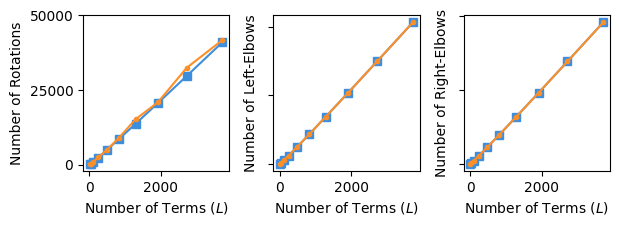

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(16 / 2.54, 6 / 2.54))

numbers_of_terms = [DATA_POINT["USP"]["number_of_terms"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
M_vals = [DATA_POINT["USP"]["maximum_number_of_active_bosonic_modes"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
# rotation_upper_bound = [(L*M*(fix_Omega+3)) for L, M in zip(numbers_of_terms, M_vals)]
# elbow_upper_bound = [(L + L*I + L*M*(fix_Omega + np.log2(fix_Omega))) for L, M, I in zip(numbers_of_terms, M_vals, number_of_modes_range)]

left_elbows_usp = [DATA_POINT["USP"]["left_elbows"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
right_elbows_usp = [DATA_POINT["USP"]["right_elbows"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
rotations_usp = [DATA_POINT["USP"]["rotations"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
nonclifford_rotations_usp = [DATA_POINT["USP"]["number_of_nonclifford_rotations"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
rescaling_factors_usp = [DATA_POINT["USP"]["rescaling_factor"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
numbers_of_qubits_usp = [DATA_POINT["USP"]["number_of_qubits"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
numbers_of_ancillae_usp = [DATA_POINT["USP"]["number_of_ancillae"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]

left_elbows_asp = [DATA_POINT["ASP"]["left_elbows"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
right_elbows_asp = [DATA_POINT["ASP"]["right_elbows"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
rotations_asp = [DATA_POINT["ASP"]["rotations"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
nonclifford_rotations_asp = [DATA_POINT["ASP"]["number_of_nonclifford_rotations"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
rescaling_factors_asp = [DATA_POINT["ASP"]["rescaling_factor"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
numbers_of_qubits_asp = [DATA_POINT["ASP"]["number_of_qubits"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
numbers_of_ancillae_asp = [DATA_POINT["ASP"]["number_of_ancillae"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]

# axes[0].plot(numbers_of_terms, rotations_usp, color=BLUE, marker='s', alpha = 1)
# axes[0].plot(numbers_of_terms, rotations_asp, color=ORANGE, marker='.', alpha = 1)
axes[0].plot(numbers_of_terms, nonclifford_rotations_usp, color=BLUE, marker='s', alpha = 1)
axes[0].plot(numbers_of_terms, nonclifford_rotations_asp, color=ORANGE, marker='.', alpha = 1)
# axes[0].plot(numbers_of_terms, rotation_upper_bound, color=RED, ls='--', alpha = 1)
axes[0].set_ylabel("Number of Rotations")
axes[0].set_xlabel("Number of Terms ($L$)")

axes[1].plot(numbers_of_terms, left_elbows_usp, color=BLUE, marker='s', alpha = 1)
axes[1].plot(numbers_of_terms, left_elbows_asp, color=ORANGE, marker='.', alpha = 1)
# axes[1].plot(numbers_of_terms, elbow_upper_bound, color=RED, ls='--', alpha = 1)
axes[1].set_ylabel("Number of Left-Elbows")
axes[1].set_xlabel("Number of Terms ($L$)")

axes[2].plot(numbers_of_terms, right_elbows_usp, color=BLUE, marker='s', alpha = 1)
axes[2].plot(numbers_of_terms, right_elbows_asp, color=ORANGE, marker='.', alpha = 1)
# axes[2].plot(numbers_of_terms, elbow_upper_bound, color=RED, ls='--', alpha = 1)
axes[2].set_ylabel("Number of Right-Elbows")
axes[2].set_xlabel("Number of Terms ($L$)")

axes[0].set_yticks([0, 25000, 50000])
axes[1].set_yticks([0, 25000, 50000])
axes[2].set_yticks([0, 25000, 50000])
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])


plt.tight_layout()
plt.savefig("../manuscript/figures/yukawa_hamiltonian_gates_vs_terms.pdf", dpi=600)

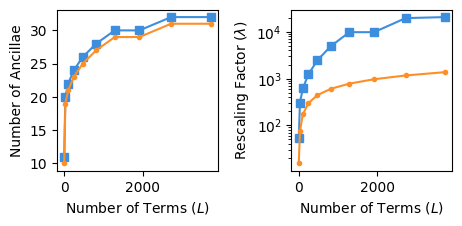

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12 / 2.54, 6 / 2.54))

# axes[0].plot(numbers_of_terms, numbers_of_qubits_usp, color=BLUE, marker='s', alpha = 1)
# axes[0].plot(numbers_of_terms, numbers_of_qubits_asp, color=ORANGE, marker='.', alpha = 1)
# axes[0].set_ylabel("Number of Qubits")
# axes[0].set_xlabel("Number of Terms ($L$)")

axes[0].plot(numbers_of_terms, numbers_of_ancillae_usp, color=BLUE, marker='s', alpha = 1)
axes[0].plot(numbers_of_terms, numbers_of_ancillae_asp, color=ORANGE, marker='.', alpha = 1)
axes[0].set_ylabel("Number of Ancillae")
axes[0].set_xlabel("Number of Terms ($L$)")

axes[1].plot(numbers_of_terms, rescaling_factors_usp, color=BLUE, marker='s', alpha = 1)
axes[1].plot(numbers_of_terms, rescaling_factors_asp, color=ORANGE, marker='.', alpha = 1)
axes[1].set_ylabel("Rescaling Factor ($\\lambda$)")
axes[1].set_xlabel("Number of Terms ($L$)")
axes[1].set_yscale("log")
# axes[1].set_xscale("log")

axes[1].set_yscale('log')
plt.tight_layout()
plt.savefig("../manuscript/figures/yukawa_hamiltonian_qubits_and_rescaling_vs_terms.pdf", dpi=600)

In [8]:
fixed_I = 2
occupation_cutoff_range = [1 << (i) for i in range(1, 11)]

DATA_FOR_FIXED_I = []
for occupation_cutoff in occupation_cutoff_range:
    start = time()
    print("----{} of {}----".format(len(DATA_FOR_FIXED_I) + 1, len(occupation_cutoff_range)))
    DATA_FOR_FIXED_I.append(generate_yukawa_circuit(fixed_I, occupation_cutoff))
    print("* {} (s) *".format(round(time() - start, 1)))

----1 of 10----
* 0.1 (s) *
----2 of 10----
* 0.1 (s) *
----3 of 10----
* 0.2 (s) *
----4 of 10----
* 0.3 (s) *
----5 of 10----
* 1.0 (s) *
----6 of 10----
* 3.2 (s) *
----7 of 10----
* 10.2 (s) *
----8 of 10----
* 28.6 (s) *
----9 of 10----
* 85.3 (s) *
----10 of 10----
* 316.7 (s) *


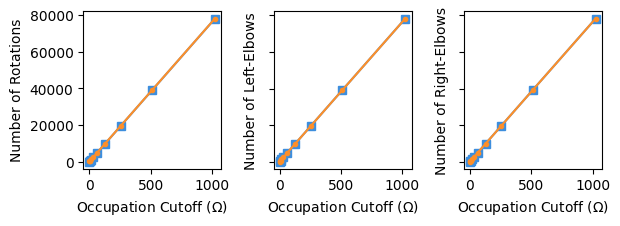

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(16 / 2.54, 6 / 2.54))

numbers_of_terms = [DATA_POINT["USP"]["number_of_terms"] for DATA_POINT in DATA_FOR_FIXED_I]
M_vals = [DATA_POINT["USP"]["maximum_number_of_active_bosonic_modes"] for DATA_POINT in DATA_FOR_FIXED_I]
# rotation_upper_bound = [(L*M*(fix_Omega+3)) for L, M in zip(numbers_of_terms, M_vals)]
# elbow_upper_bound = [(L + L*I + L*M*(fix_Omega + np.log2(fix_Omega))) for L, M, I in zip(numbers_of_terms, M_vals, number_of_modes_range)]

left_elbows_usp = [DATA_POINT["USP"]["left_elbows"] for DATA_POINT in DATA_FOR_FIXED_I]
right_elbows_usp = [DATA_POINT["USP"]["right_elbows"] for DATA_POINT in DATA_FOR_FIXED_I]
rotations_usp = [DATA_POINT["USP"]["rotations"] for DATA_POINT in DATA_FOR_FIXED_I]
nonclifford_rotations_usp = [DATA_POINT["USP"]["number_of_nonclifford_rotations"] for DATA_POINT in DATA_FOR_FIXED_I]
rescaling_factors_usp = [DATA_POINT["USP"]["rescaling_factor"] for DATA_POINT in DATA_FOR_FIXED_I]
numbers_of_qubits_usp = [DATA_POINT["USP"]["number_of_qubits"] for DATA_POINT in DATA_FOR_FIXED_I]
numbers_of_ancillae_usp = [DATA_POINT["USP"]["number_of_ancillae"] for DATA_POINT in DATA_FOR_FIXED_I]

left_elbows_asp = [DATA_POINT["ASP"]["left_elbows"] for DATA_POINT in DATA_FOR_FIXED_I]
right_elbows_asp = [DATA_POINT["ASP"]["right_elbows"] for DATA_POINT in DATA_FOR_FIXED_I]
rotations_asp = [DATA_POINT["ASP"]["rotations"] for DATA_POINT in DATA_FOR_FIXED_I]
nonclifford_rotations_asp = [DATA_POINT["ASP"]["number_of_nonclifford_rotations"] for DATA_POINT in DATA_FOR_FIXED_I]
rescaling_factors_asp = [DATA_POINT["ASP"]["rescaling_factor"] for DATA_POINT in DATA_FOR_FIXED_I]
numbers_of_qubits_asp = [DATA_POINT["ASP"]["number_of_qubits"] for DATA_POINT in DATA_FOR_FIXED_I]
numbers_of_ancillae_asp = [DATA_POINT["ASP"]["number_of_ancillae"] for DATA_POINT in DATA_FOR_FIXED_I]

axes[0].plot(occupation_cutoff_range, nonclifford_rotations_usp, color=BLUE, marker='s', alpha = 1)
axes[0].plot(occupation_cutoff_range, nonclifford_rotations_asp, color=ORANGE, marker='.', alpha = 1)
# axes[0].plot(occupation_cutoff_range, rotation_upper_bound, color=RED, ls='--', alpha = 1)
axes[0].set_ylabel("Number of Rotations")
axes[0].set_xlabel("Occupation Cutoff ($\\Omega$)")

axes[1].plot(occupation_cutoff_range, left_elbows_usp, color=BLUE, marker='s', alpha = 1)
axes[1].plot(occupation_cutoff_range, left_elbows_asp, color=ORANGE, marker='.', alpha = 1)
# axes[1].plot(occupation_cutoff_range, elbow_upper_bound, color=RED, ls='--', alpha = 1)
axes[1].set_ylabel("Number of Left-Elbows")
axes[1].set_xlabel("Occupation Cutoff ($\\Omega$)")

axes[2].plot(occupation_cutoff_range, right_elbows_usp, color=BLUE, marker='s', alpha = 1)
axes[2].plot(occupation_cutoff_range, right_elbows_asp, color=ORANGE, marker='.', alpha = 1)
# axes[2].plot(occupation_cutoff_range, elbow_upper_bound, color=RED, ls='--', alpha = 1)
axes[2].set_ylabel("Number of Right-Elbows")
axes[2].set_xlabel("Occupation Cutoff ($\\Omega$)")

axes[0].set_yticks([0, 20000, 40000, 60000, 80000])
axes[1].set_yticks([0, 20000, 40000, 60000, 80000])
axes[2].set_yticks([0, 20000, 40000, 60000, 80000])
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])


plt.tight_layout()
plt.savefig("../manuscript/figures/yukawa_hamiltonian_gates_vs_omega.pdf", dpi=600)

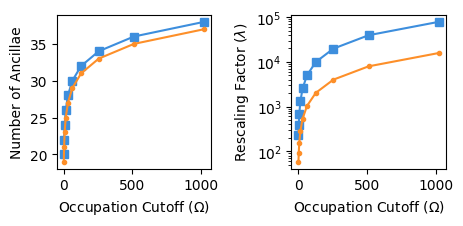

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12 / 2.54, 6 / 2.54))

# axes[0].plot(occupation_cutoff_range, numbers_of_qubits_usp, color=BLUE, marker='s', alpha = 1)
# axes[0].plot(occupation_cutoff_range, numbers_of_qubits_asp, color=ORANGE, marker='.', alpha = 1)
# axes[0].set_ylabel("Number of Qubits")
# axes[0].set_xlabel("Occupation Cutoff ($\\Omega$)")

axes[0].plot(occupation_cutoff_range, numbers_of_ancillae_usp, color=BLUE, marker='s', alpha = 1)
axes[0].plot(occupation_cutoff_range, numbers_of_ancillae_asp, color=ORANGE, marker='.', alpha = 1)
axes[0].set_ylabel("Number of Ancillae")
axes[0].set_xlabel("Occupation Cutoff ($\\Omega$)")

axes[1].plot(occupation_cutoff_range, rescaling_factors_usp, color=BLUE, marker='s', alpha = 1)
axes[1].plot(occupation_cutoff_range, rescaling_factors_asp, color=ORANGE, marker='.', alpha = 1)
axes[1].set_ylabel("Rescaling Factor ($\\lambda$)")
axes[1].set_xlabel("Occupation Cutoff ($\\Omega$)")
axes[1].set_yscale("log")
# axes[1].set_xscale("log")

axes[1].set_yscale('log')
plt.tight_layout()
plt.savefig("../manuscript/figures/yukawa_hamiltonian_qubits_and_rescaling_vs_omega.pdf", dpi=600)